# Setting up the differentiable blob

In [1]:
from phi.tf.flow import *  # Causes deprecation warnings with TF 1.15
import pylab
session = Session(None)  # Used to run the TensorFlow graph

%load_ext autoreload
%autoreload 2

Could not load resample cuda libraries: CUDA binaries not found at /home/intergalactic-mammoth/anaconda3/envs/tf/lib/python3.7/site-packages/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them







In [2]:
#Create 2 batch sim, target and source blob
#buoyancy is set to zero

world = World()
fluid = world.add(Fluid(Domain([32, 32], boundaries=CLOSED), buoyancy_factor=0.0, batch_size=2), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=[[16,5], [16, 26]], radius=3), rate=0.2));
fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
initial_state = fluid.state  # Remember the state at t=0 for later visualization
session.initialize_variables()



In [3]:
#See tensorflow variables
[print(grid.data) for grid in fluid.velocity.unstack()];

<tf.Variable 'Variable/data/0/data:0' shape=(2, 33, 32, 1) dtype=float32_ref>
<tf.Variable 'Variable/data/1/data:0' shape=(2, 32, 33, 1) dtype=float32_ref>


Building graph for frame 0
Building graph for frame 1
Building graph for frame 2
Building graph for frame 3
Building graph for frame 4
Building graph for frame 5
Building graph for frame 6
Building graph for frame 7
Building graph for frame 8
Building graph for frame 9
Building graph for frame 10
Building graph for frame 11
Building graph for frame 12
Building graph for frame 13
Building graph for frame 14
Building graph for frame 15
Building graph for frame 16
Building graph for frame 17
Building graph for frame 18
Building graph for frame 19
Computing frames...


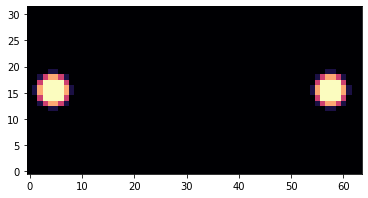

In [4]:
for frame in range(20):
  print('Building graph for frame %d' % frame)
  world.step(dt=1.5)


print('Computing frames...')
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [5]:
#Define loss function
#Want the densities of the right blob to match the ones of the left blob (target)

target = session.run(fluid.density).data[0,...]
loss = math.l2_loss(fluid.density.data[1:,...] - target)
#optim = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
optim = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)
session.initialize_variables()
print('Initial loss: %f' % session.run(loss))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Initial loss: 865.564941


In [6]:
#Run optimization

for optim_step in range(200):
  print('Running optimization step %d. %s' % (optim_step, '' if optim_step else 'The first step sets up the adjoint graph.'))
  _, loss_value = session.run([optim, loss])
  print('Loss: %f' % loss_value)

Running optimization step 0. The first step sets up the adjoint graph.
Loss: 865.564941
Running optimization step 1. 
Loss: 701.657227
Running optimization step 2. 
Loss: 668.447388
Running optimization step 3. 
Loss: 647.575317
Running optimization step 4. 
Loss: 632.640137
Running optimization step 5. 
Loss: 621.762878
Running optimization step 6. 
Loss: 613.476746
Running optimization step 7. 
Loss: 606.827393
Running optimization step 8. 
Loss: 601.252441
Running optimization step 9. 
Loss: 596.451660
Running optimization step 10. 
Loss: 592.244873
Running optimization step 11. 
Loss: 588.534058
Running optimization step 12. 
Loss: 585.248230
Running optimization step 13. 
Loss: 582.318176
Running optimization step 14. 
Loss: 579.646667
Running optimization step 15. 
Loss: 577.207397
Running optimization step 16. 
Loss: 574.960815
Running optimization step 17. 
Loss: 572.887878
Running optimization step 18. 
Loss: 570.955322
Running optimization step 19. 
Loss: 569.142273
Running o

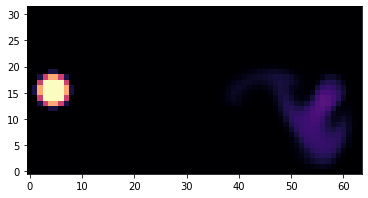

In [7]:
#See what this thing did

pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [8]:
#Checkout the optimized velocity field

optimized_velocity_field = session.run(initial_state.velocity).at_centers()

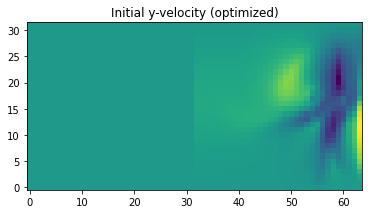

In [9]:
pylab.title('Initial y-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,0], axis=1), origin='lower')

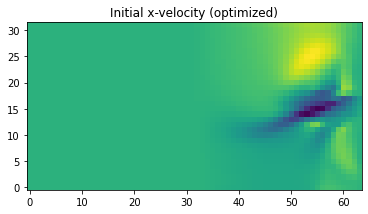

In [10]:
pylab.title('Initial x-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,1], axis=1), origin='lower')